In [1]:
from utils_project import *
from functools import reduce
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

def make_behav_preds(behav, param):
    behav_only = pd.DataFrame(columns=['decision_num', 'pred', 'real'])
    char_trajs = [behav[behav['char_role_num'] == c] for c in range(1,6)]
    for cn, test_ix in itertools.product(range(1, 6), range(12)):
        behav_params = get_behav_params(param, char_trajs[cn-1])
        train_params, test_param = behav_params[np.delete(np.arange(12), test_ix)], behav_params[test_ix] 
        dn = char_trajs[cn-1]['decision_num'].values[test_ix]
        behav_only.loc[len(behav_only), :] = [dn, np.mean(train_params, axis=0), test_param]
    behav_only.sort_values(by='decision_num', inplace=True)
    return behav_only

def plot_predictions(predicted, observed, dummy=None, title=None, ax=None, **kwargs):
    # make a plot_predictiosn function that plots predicted and observed values, with an identity line
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(predicted, observed, **kwargs)
    if dummy is not None:
        ax.scatter(predicted, dummy, color='grey', alpha=0.5, **kwargs)

    ax.plot([0,1], [0,1], color='k', linestyle='--')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Observed')

    if dummy is not None:
        min_lim = np.min([np.min(predicted), np.min(observed), np.min(dummy)])
        max_lim = np.max([np.max(predicted), np.max(observed), np.max(dummy)])
    else:
        min_lim = np.min([np.min(predicted), np.min(observed)])
        max_lim = np.max([np.max(predicted), np.max(observed)])
    ax.set_xlim([min_lim-.05,max_lim+0.05])
    ax.set_ylim([min_lim-.05,max_lim+0.05])
    if title is not None:
        ax.set_title(title)
    return ax

def calc_errors(predicted, observed):
    # calculate the Euclidean error 
    assert predicted.shape == observed.shape, f'Shapes do not match: {predicted.shape} vs {observed.shape}'
    if predicted.ndim == 1:
        errors = np.abs(predicted - observed)
    elif predicted.ndim == 2:
        errors = np.linalg.norm(predicted - observed, axis=1)
    return errors

def correlation_dists(char_coords1, char_coords2):
    return np.array([1 - scipy.stats.pearsonr(char_coords1[i], char_coords2[i])[0] \
                     for i in range(char_coords1.shape[0])])

def euclidean_dists(char_coords1, char_coords2):
    return np.linalg.norm(char_coords1 - char_coords2, axis=1)

Base directory: /Users/matty_gee/Desktop/projects/SNT_trajectory
Included n=50
Found 5 mask nifties


# Run analysis locally
- requires embeddings already

In [2]:
from scipy.interpolate import splprep, splev, BSpline
from scipy.spatial import distance
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from scipy.spatial.distance import cdist, euclidean, directed_hausdorff



# emb_fnames, _ = get_fnames('lle', ftype='Embeddings')
# for i, emb_fname in enumerate(emb_fnames):
#     for traj in ['shuffle-choices']:
#         print(f'Running {i+1}/{len(emb_fnames)} - {traj}', end='\r')
#         run_spline_analysis(emb_fname,
#                             rois=['L_HPC_thr25'],
#                             traj=traj,
#                             n_shuffles=50,
#                             scale='within')

# Organize results

### Get file names on a subject by subject basis

In [3]:
# get the files for specified algorithm
algo = 'lle'
spline_type = 'splines_scaled-within'

# get the files for diff. null models
null_models = ['circleshift', 'pseudo-choices', 'shuffle-choices', 'random-sim', 'pca', 'other-characters', 'dummy'] # , 'other-characters'] 
file_df = pd.DataFrame(columns=['sub_id', f'{algo}_fname'] + [f'{f}_fname' for f in null_models])

# get LLE files
algo_fnames, _ = get_fnames(f'{algo}*.pkl', ftype=f'{spline_type}/real')
sub_ids_ = [f.split('/')[-1].split('_')[0] for f in algo_fnames]
file_df['sub_id'] = sub_ids_
file_df[f'{algo}_fname'] = algo_fnames

for null in null_models:
    if null == 'pca':
        fnames, _ = get_fnames(f'{null}*.pkl', ftype=f'{spline_type}/{null}')
    elif null == 'dummy':
        fnames, _ = get_fnames(f'{algo}*.pkl', ftype=f'{spline_type}/real')
    else:
        fnames, _ = get_fnames(f'{algo}*{null}*.pkl', ftype=f'{spline_type}/{null}')
    
    for sub_id in sub_ids_:
        fname = [f for f in fnames if f'/{sub_id}_' in f][0]
        file_df.loc[file_df['sub_id'] == sub_id, f'{null}_fname'] = fname

## checking for bad files...
# fnames = file_df.iloc[:,1:].values.flatten()
# bad_files, good_files = [], []
# for fname in fnames:
#     try:
#         dict_ = pd.read_pickle(fname)
#         # pd.to_pickle(dict_, fname.split('.pkl')[0] + '_new.pkl')
#         good_files.append(fname)
#     except:
#         if isinstance(fname, str):
#             bad_files.append(fname)
# # print(len(bad_files) + len(good_files))
# # pd.DataFrame(bad_files).to_excel('bad_files.xlsx', index=False)
# print(len(bad_files))

Found 50 splines_scaled-within/real files
Found 50 splines_scaled-within/circleshift files
Found 50 splines_scaled-within/pseudo-choices files
Found 50 splines_scaled-within/shuffle-choices files
Found 50 splines_scaled-within/random-sim files
Found 50 splines_scaled-within/pca files
Found 50 splines_scaled-within/other-characters files
Found 50 splines_scaled-within/real files


### Get decoding errors for diff. models and rois

In [4]:
algo = 'lle'
spline_type = 'Splines_scaled-within'
overwrite = False
out_fname = f'{spline_type}_results.xlsx'

if (os.path.exists(out_fname)) & (not overwrite):

    print('Loading results')
    results_df = pd.read_excel(out_fname)
    
else:

    rois   = ['L_HPC_thr25']
    nns    = ['10nn','20nn']
    dims   = [f'{d}d' for d in range(2, 11)]
    params = ['xy'] # 'neu_2d_dist', 'pov_2d_dist']
    models = [algo, 'circleshift', 'pseudo-choices', 'shuffle-choices', 'random-sim', 'pca', 'other-characters', 'dummy']
    
    results = []
    for i, row in file_df.iterrows():
        
        print(f'Processing {i+1}/{len(file_df)}', end='\r')
        sub_id = row['sub_id']

        for model in models:
            fname = row[f'{model}_fname'] if model != 'dummy' else row[f'{algo}_fname'] # different fnames
            decoding_dict = pd.read_pickle(fname)

            for roi, dim, nn, param in itertools.product(rois, dims, nns, params):

                if (param != 'xy') & (model != algo):  # only calculate non-xy for the real algo models
                    continue

                try:
                    decoding_df = decoding_dict[roi][dim] if model == 'pca' else decoding_dict[roi][dim][nn] # no nearest neighbors param for pca
                    if 'param_name' in decoding_df:
                        decoding_df = decoding_df[decoding_df['param_name'] == param].reset_index(drop=True)
                except Exception as e:
                    print(f'Error {sub_id}, {model}: {e}')
                    continue

                # calculate prediction errors: euclidean distance(predicted xy to observed xy)
                predicted_col = 'dummy_param' if model == 'dummy' else 'pred_param'
                predicted     = np.vstack(decoding_df[predicted_col].values).astype(float).squeeze()
                observed      = np.vstack(decoding_df['param'].values).astype(float).squeeze()
                errors        = calc_errors(predicted, observed) 
                # char_errors = list(np.mean(np.array_split(errors, 5), axis=1))
                results.append([sub_id, roi, dim, nn, model, param, np.mean(errors), np.std(errors)])

                # also output the number of permutations...

    # merge the results
    results_df = pd.DataFrame(results, columns=['sub_id', 'roi', 'dim', 'nn', 'model', 'param', 'error_mean', 'error_std'])
    results_df = results_df.astype({'sub_id': int, 'error_mean': float, 'error_std': float})
    results_df = results_df.merge(data)
    results_df.to_excel(out_fname, index=False) 

results_df = results_df[results_df['sub_id'].isin(data[fd_mask]['sub_id'].values)] # ensure its only included subjects

Loading results


### Decoding errors dont differ by character or time

In [ ]:
# correlate the errors with trial number
# w, p = scipy.stats.wilcoxon(taus)
# print(f'Wilcoxon signed-rank test: W = {w}, p = {p:.3f}')
# sns.distplot(taus)
# plt.show()
# compare errors between characters...

In [ ]:
# distances not included... rerun later...
# for dim in decoding_dict['L_HPC_thr25'].keys():
#     for nn in decoding_dict['L_HPC_thr25'][dim].keys():
#         decoding_df = decoding_dict['L_HPC_thr25'][dim][nn]
#         # is 'neu_2d_dist  in decoding_df['param_name'].values:
#         if 'neu_2d_dist' not in decoding_df['param_name'].values:
#             print(dim, nn)

# Compare against null models

Test trajectory assumptions
- 'null': randomized spline fitting (prob. not ideal, b/c breaks autocorrelation in fMRI signal)
- 'circleshift': chance, using circle-shifting on each training spline
- 'dummy': predicts the middle spline location
- 'pseudo-choices': character non-specific pseudo-trajectories, from raw choices
- 'pca': linear comparison
- 'random-sim': simulated random choosing; accounts for non-choice related relationship task structure
- 'other-characters': shuffle the behavioral trajectories to see if trajectory decoding is character specific

In [21]:
algo = 'lle'
dims = [f'{d}d' for d in range(2, 11)]
nns  = ['10nn', '20nn']
p_type = 'p_left'
null_models = ['circleshift', 'pseudo-choices', 'shuffle-choices', 'random-sim', 'pca', 'other-characters', 'dummy']
stats_res = []
for dim, nn in itertools.product(dims, nns):
    for roi in ['L_HPC_thr25']:
        roi_res  = results_df[(results_df['roi'] == roi) & 
                                (results_df['nn'] == nn) &
                                (results_df['dim'] == dim) & 
                                (results_df['param'] == 'xy')]

        # error from model
        real_res = roi_res[(roi_res['model'] == algo)]
        error    = real_res['error_mean'].values

        for null in null_models: 

            # if 'thr' in null: # roi-roi comp
            #     roi_res_   = results_df[results_df['roi'] == f'{roi.split("_")[0]}_{null}']
            #     null_error = roi_res_[roi_res_['model'] == algo]['error']     

            # error from null model
            null_res  = roi_res[roi_res['model'] == null]
            assert np.all(real_res['sub_id'].values == null_res['sub_id'].values), 'Subjects do not match'
            null_error = null_res['error_mean'].values
            assert len(error) == len(null_error), f'Lengths do not match: {len(error)} vs {len(null_error)}'       

            # calculate error difference
            error_diff = error - null_error
            if null in ['random-sim', 'circleshift', 'pseudo-choices']:
                error_diff = error_diff / null_res['error_std'].values # z-score wrt permutation distribution

            # t-tests against 0
            for sample in [['Initial'], ['Validation']]:

                mask = real_res['sample'].isin(sample)
                sample = 'Combined' if len(sample) == 2 else sample[0]
                df_  = pd.DataFrame([[sample, np.sum(mask), roi, nn, dim, null, np.mean(error_diff[mask])]], 
                                    columns=['sample', 'n', 'roi', 'nn', 'dim', 'null_model', 'error_diff'])

                ttest_df = run_ols(error_diff[mask], popmean=0)[0]
                ttest_df = ttest_df.iloc[0, 8:].to_frame().T
                stats_res.append(pd.concat([df_, ttest_df], axis=1))
        stats_df = pd.concat(stats_res).reset_index(drop=True)
    stats_df = stats_df.drop(columns=['p', 'p_right'])

    for i, row in stats_df.iterrows():
        for p_thresh in [0.001, 0.005, 0.01, 0.05]:
            if row[p_type] < p_thresh:
                stats_df.loc[i, p_type] = p_thresh
                break

stats_df_ = stats_df[~stats_df['null_model'].isin(['other-characters'])]
print_df(stats_df_[(stats_df_['dim'].isin(['5d','6d','7d','8d'])) & (stats_df_['nn']=='10nn') & (stats_df_['roi']=='L_HPC_thr25')])

|     | sample     |   n | roi         | nn   | dim   | null_model      |   error_diff |         se |     95%_lb |      95%_ub |         t |    p_left |
|----:|:-----------|----:|:------------|:-----|:------|:----------------|-------------:|-----------:|-----------:|------------:|----------:|----------:|
|  84 | Initial    |  18 | L_HPC_thr25 | 10nn | 5d    | circleshift     |   -0.216564  | 0.0451933  | -0.311913  | -0.121214   |  -4.79195 | 0.001     |
|  85 | Validation |  32 | L_HPC_thr25 | 10nn | 5d    | circleshift     |   -0.24231   | 0.0236395  | -0.290523  | -0.194097   | -10.2502  | 0.001     |
|  86 | Initial    |  18 | L_HPC_thr25 | 10nn | 5d    | pseudo-choices  |   -0.0498678 | 0.03557    | -0.124914  |  0.0251782  |  -1.40196 | 0.0894605 |
|  87 | Validation |  32 | L_HPC_thr25 | 10nn | 5d    | pseudo-choices  |   -0.0781393 | 0.0266447  | -0.132482  | -0.0237971  |  -2.93264 | 0.005     |
|  88 | Initial    |  18 | L_HPC_thr25 | 10nn | 5d    | shuffle-choices |   -0.021

# Plots

### Summary figure

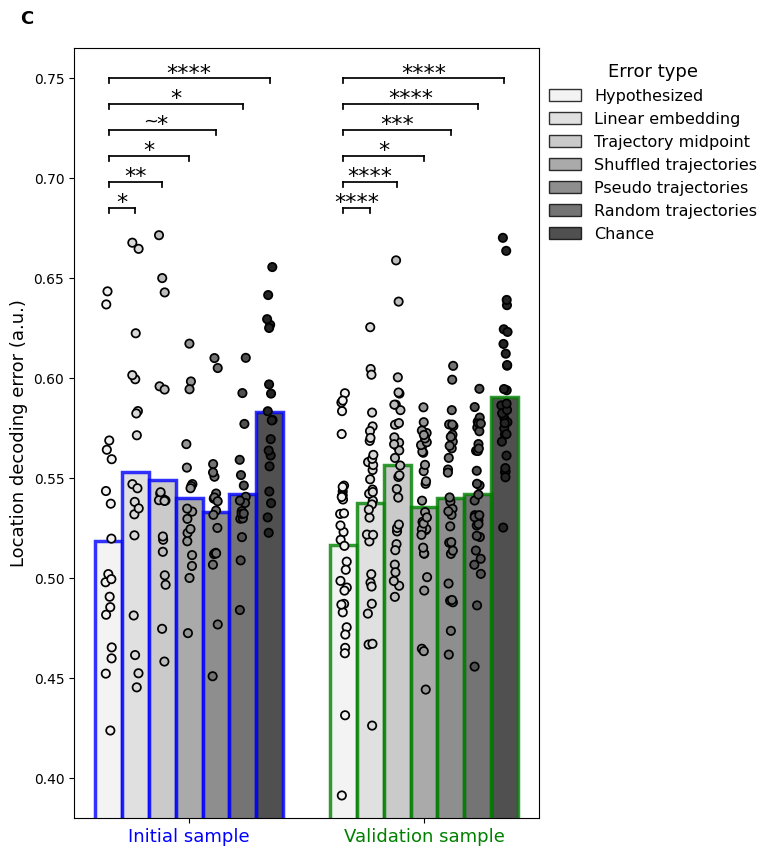

In [30]:
#------------------------------------------------------------------------------------------
# organize 
#------------------------------------------------------------------------------------------

dim = '5d'
nn  = '10nn'
dict_ = {'lle': 'Hypothesized',
        'pca': 'Linear embedding',
        'dummy': 'Trajectory midpoint',
        'shuffle-choices': 'Shuffled trajectories',
        'pseudo-choices': 'Pseudo trajectories',
        'random-sim': 'Random trajectories',
        'other-characters': 'Relationship specificity',
        'circleshift': 'Chance'}
models = ['lle', 'pca', 'dummy', 'shuffle-choices', 'pseudo-choices', 'random-sim', 'circleshift'] 
labels = [dict_[m] for m in models]

# compute differences btween error types
stats_df_   = stats_df[(stats_df['dim']==dim) & (stats_df['nn']==nn)]
results_df_ = results_df.iloc[:, :9]
results_df_ = results_df_[(results_df_['dim']==dim) & (results_df_['nn']==nn)]
lle_df = results_df_[results_df_['model']=='lle']
error  = lle_df['error_mean'].values
error_diffs = []
for null in models[1:]:
    null_df   = results_df_[results_df_['model']==null]
    null_subs = null_df['sub_id'].values
    assert np.all(lle_df['sub_id'].values == null_subs), 'Subjects do not match'
    null_error = null_df['error_mean'].values
    error_diffs.append(error.astype(float) - null_error.astype(float))
error_diff_df = pd.DataFrame(error_diffs).T
error_diff_df.columns = models[1:]
error_diff_df.insert(0, 'sub_id', lle_df['sub_id'].values)
error_diff_df.insert(1, 'sample', lle_df['sample'].values)


#------------------------------------------------------------------------------------------
# plot
#------------------------------------------------------------------------------------------

lw = 1
fig, ax = plt.subplots(figsize=(6, 10))
add_subfig_letter(ax, 'C', x=-.088, y=1.05, fontsize=label_fontsize)
plot_pal = 'Greys'
plot_colors = sns.color_palette('Greys', n_colors=15)
sns.barplot(data=results_df_, x='sample', y='error_mean', hue='model', hue_order=models, order=['Initial', 'Validation'],
            palette=plot_pal, edgecolor=ec, linewidth=lw, alpha=.8, ci=None, ax=ax)
sns.stripplot(data=results_df_, x='sample', y='error_mean', hue='model', hue_order=models, order=['Initial', 'Validation'], dodge=True, 
              palette=plot_pal, size=6, edgecolor=ec, linewidth=lw+0.25, alpha=1, ax=ax)
ax.set_ylabel('Location decoding error (a.u.)', fontsize=label_fontsize)
ax.set_xlabel('', fontsize=label_fontsize)
ax.set_xticklabels(['Initial sample', 'Validation sample'], fontsize=label_fontsize)
ax.set_ylim([0.38, 0.765])

# legends
handles = ax.get_legend_handles_labels()[0][len(models):] # do this before changing colors below...
ax.legend(title='Error type', title_fontsize=label_fontsize, frameon=False,
          handles=handles, labels=labels,
          loc='upper right', bbox_to_anchor=(1.5, 1), 
          fontsize=legend_fontsize+2)

# color the bars and points to signify sample 
for i, bar in enumerate(ax.patches):
    color = sample_colors[0] if i % 2 == 0 else sample_colors[1]
    bar.set_edgecolor(color)
    bar.set_linewidth(lw+1.5)
    if i < 2: ax.get_xticklabels()[i].set_color(color)

# add stats
init_lle, val_lle = ax.patches[0], ax.patches[1]
l = 1.25
for s, (sample, bar) in enumerate({'Initial': init_lle, 'Validation':val_lle}.items()):
    
    # lle model
    lle_x = bar.get_x() + bar.get_width()/2
    lle_y = bar.get_height()

    # null models
    for n, null in enumerate(models[1:]):

        y = .685 + .013 * n

        # evens on left side, odds on right side
        n = (n+1)*2 if s == 0 else (n+1)*2 + 1
        null_x = ax.patches[n].get_x() + ax.patches[n].get_width()/2
        ax.plot([lle_x, null_x], [y, y], color='k', linewidth=l)
        ax.plot([lle_x, lle_x],[y, y-.0025], color='k', linewidth=l)
        ax.plot([null_x, null_x],[y, y-.0025], color='k', linewidth=l)

        # stars for significance
        # null_color = plot_colors[n*3]
        n_stars = 0
        pvalue = stats_df_[(stats_df_['sample']==sample)& (stats_df_['null_model']==null)]['p_left'].values[0]
        for p, p_thresh in enumerate([0.05, 0.01, 0.005, 0.001]):
            if pvalue == p_thresh:
                n_stars = p+1
                star_str = '*'*n_stars
        if n_stars == 0:
            if pvalue < 0.1:
                ax.text((lle_x + null_x)/2, y-.0025, '*', color='black', ha='center', va='bottom', fontsize=label_fontsize+3)
                ax.text((lle_x + null_x-.1)/2, y, '~', color='black', ha='center', va='bottom', fontsize=label_fontsize)
            else:
                continue
        else:
            ax.text((lle_x + null_x)/2, y-.0025, star_str, color='black', ha='center', va='bottom', fontsize=label_fontsize+3)
        
save_figure(fig, f'{fig_dir}/fig-4b_trajectory-decoding')

### All dimensions 2-10

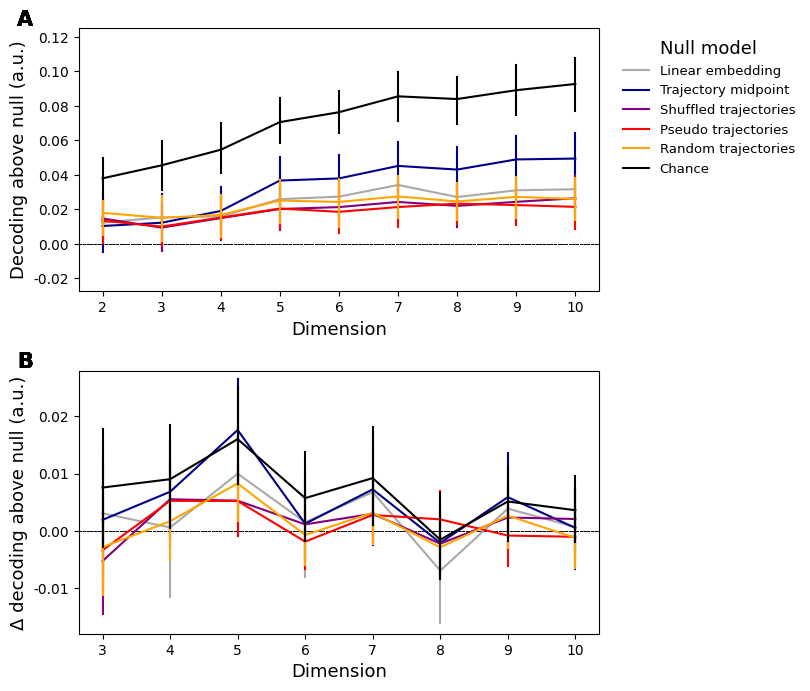

In [17]:
from scipy.stats import ttest_rel

null_dict = {'Linear embedding': 'pca',
            'Trajectory midpoint': 'dummy',
            'Shuffled trajectories': 'shuffle-choices', 
            'Pseudo trajectories': 'pseudo-choices',
            'Random trajectories': 'random-sim',
            'Chance': 'circleshift'}


#------------------------------------------------------------------------------------------
# compute 
#------------------------------------------------------------------------------------------

# organize
results_df_  = results_df[(results_df['nn']=='10nn')]
results_lle  = results_df_[results_df_['model']=='lle']

error_diffs, error_diffs_prev = {}, {}
for null_name, null in null_dict.items():

    results_null = results_df_[results_df_['model']==null]
    assert np.all(results_lle['sub_id'].values == results_null['sub_id'].values), 'Subjects do not match'

    # get the diffs. between lle & null
    diffs   = results_null['error_mean'].values - results_lle['error_mean'].values
    results = results_lle[['sample', 'dim']]
    results[f'error_against_{null}'] = diffs
    error_diffs[null_name] = results

    diff_dfs = []
    for d in range(3, 11):

        # pvals_against_0[null][f'{d}d'] = ttest_1samp(diffs[results['dim']==f'{d}d'], popmean=0, alternative='greater')[1]
        # pvals_against_prev[null][f'{d}d'] = ttest_1samp(diff, popmean=0, alternative='greater')[1] # idk if should be directed or not 

        sample = results['sample'].values[results['dim']==f'{d}d']

        curr = diffs[results['dim']==f'{d}d']
        prev = diffs[results['dim']==f'{d-1}d']
        diff = curr - prev
        
        diff_df = pd.DataFrame(diff, columns=['diff_against_prev'])
        diff_df.insert(0, 'dim', f'{d}d')
        diff_df.insert(0, 'sample', sample)
        diff_dfs.append(diff_df)
    error_diffs_prev[null_name] = pd.concat(diff_dfs)

#------------------------------------------------------------------------------------------
# plot 
#------------------------------------------------------------------------------------------

lw = 1.5
colors = ['darkgrey', 'darkblue', 'purple', 'red', 'orange', 'black']
fig, axs = plt.subplots(2, 1, figsize=(9, 7))
for i, (null_name, null_var) in enumerate(null_dict.items()):

    # error diff of LLE v. null
    ax = axs[0]
    add_subfig_letter(ax, 'A', x=-.088, y=1.07, fontsize=title_fontsize)
    sns.lineplot(x='dim', y=f'error_against_{null_var}', data=error_diffs[null_name],
                    errorbar=('ci', 95), err_style="bars",
                    alpha=1, 
                    color=colors[i],
                    linewidth=lw, 
                    label=null_name,
                    ax=ax)
    ax.set_ylabel('Decoding above null (a.u.)', fontsize=label_fontsize)
    ax.set_xlabel('Dimension', fontsize=label_fontsize)
    ax.set_xticklabels(np.arange(2,11), fontsize=tick_fontsize)
    ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()], fontsize=tick_fontsize)
    ax.axhline(0, linewidth=.5, color='black', linestyle='--', zorder=-5)
    ax.set_ylim([-0.0275, 0.125])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='Null model', title_fontsize=label_fontsize, frameon=False,
                loc='upper right', bbox_to_anchor=(1.4, 1), 
                fontsize=legend_fontsize)
    
    # error improvement of LLE of current dim above previous dim
    ax = axs[1]
    add_subfig_letter(ax, 'B', x=-.088, y=1.07, fontsize=title_fontsize)
    sns.lineplot(x='dim', y=f'diff_against_prev', data=error_diffs_prev[null_name],
                errorbar=('ci', 95), err_style="bars",
                alpha=1, 
                color=colors[i],
                linewidth=lw, 
                label=null_name,
                ax=ax)
    ax.set_ylabel(u'Δ decoding above null (a.u.)', fontsize=label_fontsize)
    ax.set_xlabel('Dimension', fontsize=label_fontsize)
    ax.set_xticklabels(np.arange(3,11), fontsize=tick_fontsize)
    ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()], fontsize=tick_fontsize)
    ax.set_ylim([-0.018, 0.028])
    ax.axhline(0, linewidth=.5, color='black', linestyle='--', zorder=-5)
    ax.get_legend().remove()

plt.tight_layout()
save_figure(fig, f'{fig_dir}/fig-supp_trajectory-decoding_across-dims')

### Trial-level predictions
- rethink the normalization step: should I normalize within each character, or across characters?
- across means characters will share info: but maybe this is ok b/c we kind of expect the manifold to be about all of them...

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), 
                             np.diag([0.5, 2, 0.75, 1]))

observed_ = np.hstack([np.arange(len(observed))[:,np.newaxis], observed])
ax.scatter(xs=observed_[:,1], ys=observed_[:,0], zs=observed_[:,2],
           c='red', s=30)

lle_predicted_ = np.hstack([np.arange(len(lle_predicted))[:,np.newaxis], lle_predicted])
ax.scatter(xs=lle_predicted_[:,1], ys=lle_predicted_[:,0], zs=lle_predicted_[:,2],
           c='k', s=30)
# for i in range(lle_predicted_.shape[0]-1):
#     ax.plot(lle_predicted_[i:i+2,1], lle_predicted_[i:i+2,0], lle_predicted_[i:i+2,2], 
#             color='black', linewidth=1)

# Get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.tight_layout()

In [ ]:
def plot_spline_predictions_1d(res_df, colors=None):

    if colors is None: colors = ['red', 'black', 'darkgrey', 'grey']
    res_df.sort_values('decision_num', inplace=True)

    # plot real and predicted
    fig, axs = plt.subplots(1, 2, figsize=(14, 3), gridspec_kw={'width_ratios': [1, 3]})
    ax = axs[0]
    ax.scatter(x=res_df['predicted_dist'], y=res_df['observed_dist'], s=20, color=colors[1], edgecolors='black', linewidths=0.5)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle='--', linewidth=0.5)
    ax.set_ylabel('real', fontsize=14)
    ax.set_xlabel('predicted', fontsize=14)
    max_lim = np.max([np.max(res_df['predicted_dist']), np.max(res_df['observed_dist'])])
    ax.set_xlim([-0.03, max_lim+0.05])
    ax.set_ylim([-0.03, max_lim+0.05])
    ax.set_xticks(np.arange(0, max_lim+0.1, 0.5))
    ax.set_yticks(np.arange(0, max_lim+0.1, 0.5))

    ax = axs[1]
    s = 8
    # ax.scatter(x=res_df['decision_num'], y=res_df['predicted_dist'], s=s, color=colors[0], alpha=1)
    # ax.scatter(x=res_df['decision_num'], y=res_df['observed_dist'], s=s, color=colors[1], alpha=1)
    # ax.scatter(x=res_df['decision_num'], y=res_df['pca_predicted_dist'], s=s, color=colors[2], alpha=.5)

    ax.plot(res_df['decision_num'], res_df['predicted_dist'], color=colors[0], alpha=0.5)
    ax.plot(res_df['decision_num'], res_df['observed_dist'], color=colors[1], alpha=1)
    # ax.plot(res_df['decision_num'], res_df['pca_predicted_dist'], color=colors[2], alpha=.25)
    ax.plot(res_df['decision_num'], res_df['dummy_predicted_dist'], color=colors[2], alpha=1, linestyle='-', linewidth=1)
    # ax.plot(res_df['decision_num'], res_df['chance_dist'], color=colors[3], alpha=1, linestyle='--', linewidth=1)
   
    ax.legend(['Behavior', 'Model', 'Chance'], 
              frameon=False, fontsize=tick_fontsize, bbox_to_anchor=(1, 1))
    ax.set_yticks(np.arange(0, max_lim+0.1, 0.5))
    ax.set_ylabel('Distance', fontsize=label_fontsize)
    ax.set_xticks(np.arange(0, 61, 5))
    ax.set_xlabel('Interaction', fontsize=label_fontsize)

    return ax

roi = 'L_HPC_thr25'
dim, nn, param = '5d', '10nn', 'xy'
lle_fnames = file_df['lle_fname'].values
taus = []
for lle_fname in lle_fnames:

    sub_id = lle_fname.split('/')[-1].split('_')[0]
    pca_fname = file_df[file_df['sub_id'] == sub_id]['pca_fname'].values[0]
    circleshift_fname = file_df[file_df['sub_id'] == sub_id]['circleshift_fname'].values[0]
    
    # get decoding dfs
    lle_decoding_df = pd.read_pickle(lle_fname)[roi][dim][nn]
    lle_decoding_df = lle_decoding_df[lle_decoding_df['param_name'] == param].reset_index(drop=True) # only current param
    lle_decoding_df = lle_decoding_df.sort_values(by='decision_num').reset_index(drop=True)
    
    pca_decoding_df = pd.read_pickle(pca_fname)[roi][dim]
    pca_decoding_df = pca_decoding_df.sort_values('decision_num').reset_index(drop=True)
    pca_decoding_df = pca_decoding_df[pca_decoding_df['param_name'] == param].reset_index(drop=True)
    
    chance_decoding_df = pd.read_pickle(circleshift_fname)[roi][dim][nn]
    chance_decoding_df = chance_decoding_df.sort_values('decision_num').reset_index(drop=True)
    chance_decoding_df = chance_decoding_df[chance_decoding_df['param_name'] == param].reset_index(drop=True)

    # calculate prediction errors: euclidean_distance(predicted xy, observed xy)
    observed  = np.vstack(lle_decoding_df['param'].values).astype(float).squeeze()

    lle_predicted = np.vstack(lle_decoding_df['pred_param'].values).astype(float).squeeze()
    lle_errors    = calc_errors(lle_predicted, observed)

    chance_observed  = np.vstack(chance_decoding_df['param'].values).astype(float).squeeze()
    chance_predicted = np.vstack(chance_decoding_df['pred_param'].values).astype(float).squeeze()
    chance_errors    = calc_errors(chance_predicted, chance_observed)
    chance_predicted_avg = np.vstack(chance_decoding_df.groupby('decision_num')['pred_param'].mean().values)

    dummy_predicted = np.vstack(lle_decoding_df['dummy_param'].values).astype(float).squeeze()
    dummy_errors    = calc_errors(dummy_predicted, observed)

    pca_predicted = np.vstack(pca_decoding_df['pred_param'].values).astype(float).squeeze()
    pca_errors    = calc_errors(pca_predicted, observed)

    observed_dists         = np.linalg.norm(observed, axis=1)
    lle_predicted_dists    = np.linalg.norm(lle_predicted, axis=1)
    # chance_predicted_dists = np.linalg.norm(chance_predicted_avg, axis=1)
    dummy_predicted_dists  = np.linalg.norm(dummy_predicted, axis=1)
    pca_predicted_dists    = np.linalg.norm(pca_predicted, axis=1)
    
    df = pd.DataFrame([lle_predicted_dists, pca_predicted_dists, dummy_predicted_dists, observed_dists, lle_errors]).T
    df.columns = ['predicted_dist',  'pca_predicted_dist', 'dummy_predicted_dist', 'observed_dist', 'errors']
    df.insert(0, 'decision_num', np.arange(1,61))

    # # ax = plot_spline_predictions_1d(df)
    # # ax.set_title(sub_id)
    # chance_errors_ = np.mean(np.array_split(chance_errors, 60), 1)
    # fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # sns.regplot(x=pca_errors, 
    #             y=lle_errors, color='orange',
    #             scatter_kws={'s': 20, 'edgecolors':'black', 'linewidths':0.5}, ax=ax)
    # sns.regplot(x=chance_errors_, 
    #             y=lle_errors, color='blue',
    #             scatter_kws={'s': 20, 'edgecolors':'black', 'linewidths':0.5}, ax=ax)    
    # ax.set_xlabel('Chance error', fontsize=14)
    # ax.set_ylabel('Model error', fontsize=14)
    # plt.show()

    # chance_errors_ = np.mean(np.array_split(chance_errors, 60), 1)
    # fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # sns.regplot(x=np.arange(1,61), 
    #             y=lle_errors, color='blue',
    #             scatter_kws={'s': 20, 'edgecolors':'black', 'linewidths':0.5}, ax=ax)
    # sns.regplot(x=np.arange(1,61),  
    #             y=pca_errors, color='orange',
    #             scatter_kws={'s': 20, 'edgecolors':'black', 'linewidths':0.5}, ax=ax)   
    # sns.regplot(x=np.arange(1,61),  
    #             y=chance_errors_, color='red',
    #             scatter_kws={'s': 20, 'edgecolors':'black', 'linewidths':0.5}, ax=ax) 
    # ax.set_xlabel('Chance error', fontsize=14)
    # ax.set_ylabel('Model error', fontsize=14)
    # plt.show()


    tau, p = scipy.stats.kendalltau(lle_errors, np.arange(1,61))
    taus.append(tau)

# for s in range(15):
#     fig, axs = plt.subplots(1, 2, figsize=(14, 3), gridspec_kw={'width_ratios': [1, 3]})
#     subj = subj_predictions['L_HPC_10']['pov_dist']['knn100'][s]
#     plot_spline_predictions_1d(df)

In [ ]:
# character_labels_ = remove_neutrals(character_labels)

# for i, row in file_df.iloc[10:20,:].iterrows():
    
#     print(f'Processing {i+1}/{len(file_df)}', end='\r')
#     sub_id = row['sub_id']
#     decoding_dict = pd.read_pickle(row[f'{algo}_fname'])

#     # get decoding df
#     decoding_df = decoding_dict['L_HPC_thr25']['10d']['10nn'] 
#     decoding_df = decoding_df[decoding_df['param_name'] == 'xy'].reset_index(drop=True) # only current param

#     # calculate prediction errors: euclidean distance(predicted xy to observed xy)
#     predicted = np.vstack(decoding_df['pred_param'].values).astype(float).squeeze()
#     observed  = np.vstack(decoding_df['param'].values).astype(float).squeeze()
#     errors    = calc_errors(predicted, observed)

#     fig, ax = plt.subplots(figsize=(5,5))
#     for c in range(1, 2):

#         observed_  = observed[character_labels_ == c]
#         predicted_ = predicted[character_labels_ == c]
#         color = character_colors[c-1]
#         ax.scatter(observed_[:,0], observed_[:,1], 
#                   edgecolors=color, facecolors='White',
#                   label='Observed')
#         for i in range(observed_.shape[0]-1):
#             ax.plot([observed_[i,0], observed_[i+1,0]], 
#                     [observed_[i,1], observed_[i+1,1]], 
#                     color=color, alpha=0.5)
        
#         ax.scatter(predicted_[:,0], predicted_[:,1], 
#                 edgecolors='black', color=color,
#                 label='Predicted')
#         for i in range(predicted_.shape[0]-1):
#             ax.plot([predicted_[i,0], predicted_[i+1,0]], 
#                     [predicted_[i,1], predicted_[i+1,1]], 
#                     color=color, alpha=1)
#         # for i in range(predicted_.shape[0]-1):
#         #     ax.plot([predicted_[i,0], predicted_[i+1,0]], 
#         #             [predicted_[i,1], predicted_[i+1,1]], 
#         #             color=color, alpha=0.5)
#     # add vertical and horizontal lines through 0.5
#     ax.axhline(0.5, color='k', linestyle='--', zorder=-5)
#     ax.axvline(0.5, color='k', linestyle='--', zorder=-5)
#     ax.set_ylim(-0.05, 1.05)
#     ax.set_xlim(-0.05, 1.05)
#     ax.set_title(np.round(np.mean(errors), 3))
#     # plot_social_space(ax, origin_size=100)
#     plt.show()


# Improving spline analysis

In [ ]:
trajectory = np.array([[0., 0.], [1, 0.], [2, 0.], [2, 1], [2, 2], [3 , 2], [3 , 3], [3 , 2], [4, 2], [4, 3], [4, 4], [4, 5], [4, 4]]) / 6
fig, ax = plot_social_space(figsize=(5, 5), label_fontsize=label_fontsize)
ax.plot(*trajectory.T, color='red', linewidth=2, linestyle='-', alpha=1, zorder=0)
ax.scatter(*trajectory.T, color='red', edgecolor='black', linewidth=1, alpha=1, s=50, zorder=0)
plt.show()

In [ ]:
# spl_decoder = SplineDecoder(s=s, k=1, sort=False)
# spl_decoder.fit_transform(char_emb_train.T)
# pred_loc  = spl_decoder.predict(char_emb_test.T)[0] # predicted location

# DISCARDS

# Nonlinearity
- see if can estimate something like nonlinearity in the behavioral trajectories to test whether that correlates with how big the diff. between LLE and PCA is?

In [ ]:
def calculate_curvature(x, y):

    # Convert lists to numpy arrays if they aren't already
    x = np.array(x)
    y = np.array(y)

    # Compute the second derivatives
    x1 = np.gradient(x)
    y1 = np.gradient(y)
    x2 = np.gradient(x1)
    y2 = np.gradient(y1)

    # Compute the curvature (k)
    curvature = (x1 * y2 - y1 * x2) / np.power(x1**2 + y1**2, 3/2)
    return curvature

def count_right_angle_turns(x, y):
    turns = 0
    # Iterate through the list of points
    for i in range(1, len(x) - 1):
        # Check if there is a turn at the current point by comparing slopes
        if (x[i-1] == x[i] and y[i] == y[i+1]) or (y[i-1] == y[i] and x[i] == x[i+1]):
            turns += 1
    return turns

def get_regression_res(x, y):
    
    # Fit a linear regression line to the trajectory data
    a, b = np.polyfit(x, y, deg=1)

    # Calculate the estimated y values
    y_hat = a * x + b

    # Calculate the residuals (the difference between the observed and estimated y values)
    residuals = y - y_hat

    # Calculate the sum of the squares of residuals, which can be used as a measure of non-linearity
    return np.sum(residuals**2)

In [ ]:
roi_res = results_df[(results_df['roi'] == roi) & 
                        (results_df['nn'] == '10nn') &
                        (results_df['dim'] == '5d') & 
                        (results_df['param'] == 'xy')]
roi_res_lle = roi_res[roi_res['model'] == 'lle']
roi_res_pca = roi_res[roi_res['model'] == 'pca']
assert len(roi_res_lle) == len(roi_res_pca) == 50
assert np.all(roi_res_lle['sub_id'].values == roi_res_pca['sub_id'].values)
error_diffs = roi_res_lle['error_mean'].values - roi_res_pca['error_mean'].values
consistency = roi_res_lle['consistency_mean']
samples = roi_res_lle['sample'].values

# estimate behavioral linearity
nonlinear_ests = []
for sub_id in roi_res_lle['sub_id'].values:
    if len(str(sub_id)) == 1: 
        behavior = load_behavior(f"{sub_id:02d}")
    else:
        behavior = load_behavior(sub_id)

    xys = behavior[['affil_coord', 'power_coord']].values
    char_xys = organize_by_character(xys)

    # counting the number of right angle turns... maybe normalize by how many are forced (when going from affil to power for example)
    turns = np.mean([count_right_angle_turns(char_xys[c][:,0], char_xys[c][:,1]) for c in range(5)])
    # residuals = np.mean([get_regression_res(char_xys[c][:,0], char_xys[c][:,1]) for c in range(5)])
    residuals = np.mean(get_regression_res(xys[:,0], xys[:,1]))
    nonlinear_ests.append(residuals)
nonlinear_ests = np.array(nonlinear_ests)

# plot the regplot
fig, ax = plt.subplots(figsize=(5,5))
for s, sample in enumerate(['Initial', 'Validation']):
    mask = samples == sample
    sns.regplot(x=nonlinear_ests[mask], y=error_diffs[mask],
                color=sample_colors[s], ci=None,
                scatter_kws={'alpha': 0.8, 'edgecolor': 'k', 'linewidth': 0.5},
                ax=ax)
    rho, p = scipy.stats.spearmanr(nonlinear_ests[mask], error_diffs[mask])
    if rho > 0: p = p/2 # expect this to be positive...
    ax.annotate(f'$\\rho$ = {rho:.2f}\np = {p:.4f}', 
                xy=(0.75, 0.25-s*.1), color=sample_colors[s], 
                xycoords='axes fraction', fontsize=10)
ax.set_xlabel('Behavioral linearity', fontsize=label_fontsize)
ax.set_ylabel('Error diff.: LLE - PCA', fontsize=label_fontsize)
ax.set_title('Linearity effect', fontsize=title_fontsize)
plt.show()